# **Twitter Sentiment Analysis**

Adrià De Angulo

<br>

> Note: before running the cells below, please enable GPU acceleration in Google Colab.

# Dependencies



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# sklearn
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import re
import time

from collections import defaultdict

import random
from random import sample
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00


In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [ ]:
!pip install gdown # Install this package to download files from Google Drive
import gdown

In [ ]:
class style():
  RED = '\033[31m'
  GREEN = '\033[32m'
  BLUE = '\033[34m'

# Importing the data

In [ ]:
!gdown 1m2kD4XVd-w5UXOG6e4179CUQJ3u7xgvu

Downloading...
From: https://drive.google.com/uc?id=1m2kD4XVd-w5UXOG6e4179CUQJ3u7xgvu
To: /content/data.zip
100% 85.5M/85.5M [00:03<00:00, 25.5MB/s]


In [ ]:
!unzip -o '/content/data.zip'

Archive:  /content/data.zip
   creating: data/
  inflating: __MACOSX/._data         
  inflating: data/.DS_Store          
  inflating: __MACOSX/data/._.DS_Store  
  inflating: data/citypulse.dublin_city_council.test.csv  
  inflating: __MACOSX/data/._citypulse.dublin_city_council.test.csv  
  inflating: data/Sentiment140-test.csv  
  inflating: __MACOSX/data/._Sentiment140-test.csv  
  inflating: data/Sentiment140-train.csv  
  inflating: __MACOSX/data/._Sentiment140-train.csv  


In [ ]:
# Importing S140_train and S140_test datasets
S140_train = pd.read_csv('/content/data/Sentiment140-train.csv',  header=None, encoding='latin-1')
S140_test = pd.read_csv('/content/data/Sentiment140-test.csv',    header=None, encoding='latin-1')

In [ ]:
S140_train.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Let's rename the columns to have a better understanding.

In [ ]:
# Renaming columns
S140_train.columns = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']

In [ ]:
S140_train.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


> Note: All the datasets used in this notebook follow the same nomenclature for sentiment values, which is:
  *   0 = Negative
  *   2 = Neutral
  *   4 = Positive

In [ ]:
# Getting some info about the dataset
S140_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   query      1600000 non-null  object
 4   user       1600000 non-null  object
 5   tweet      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


Apart from indicating the total amount of samples (1.6M), the command above shows that none of the columns have missing values.

In [ ]:
# Removing the columns that don't contain relevant data for the experiments
S140_train = S140_train[['sentiment','tweet']]

In [ ]:
S140_train.head()

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


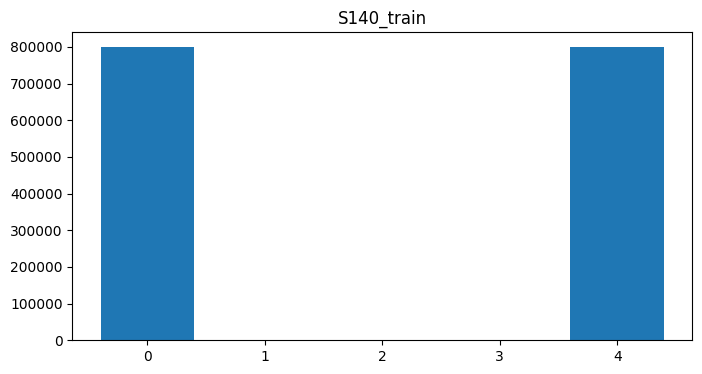

In [ ]:
# Visualize the S140_train data
val_count_train = S140_train.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count_train.index, val_count_train.values)
plt.title("S140_train")
plt.show()

As we see in the plot, we have a balanced train dataset.

Now let's take a look into the S140_test dataset.

In [ ]:
S140_test.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [ ]:
# Renaming columns
S140_test.columns = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']

In [ ]:
S140_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  498 non-null    int64 
 1   id         498 non-null    int64 
 2   date       498 non-null    object
 3   query      498 non-null    object
 4   user       498 non-null    object
 5   tweet      498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


As we see, the test dataset is very small.

In a real world scenario, if we wanted to take conclusions if our models are good or not this test dataset would be quite small.

For the development of the following experiments, we'll keep it as it is, but a simple approach to solve this problem, would be splitting a subset of the training data to use it in the test stage.

Lastly, I would also recommend having a validation dataset too, to detect if our model is overfitting.

In [ ]:
# Removing the columns that don't contain relevant data for the experiments
S140_test = S140_test[['sentiment','tweet']]

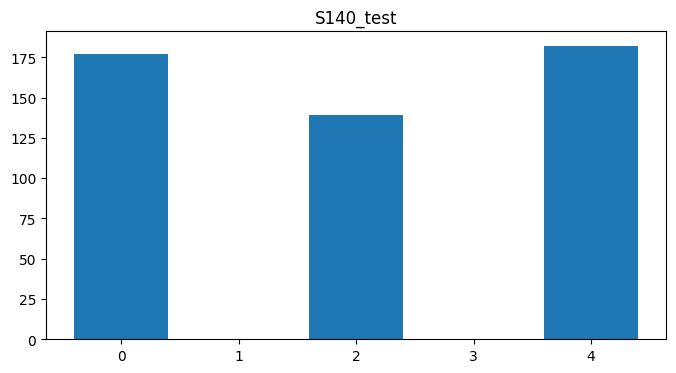

In [ ]:
# Visualize the S140_test data
val_count_test = S140_test.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count_test.index, val_count_test.values)
plt.title("S140_test")
plt.show()

Here we encounter another problem:

The train data contains only "Negative" and "Positive" labeled tweets, but the test data has also some labeled as "Neutral". This will be problematic as when we train our models, they won't be able to learn how are "Neutral" tweets, so evaluating our models with a test dataset that contains a different label than those in the train one makes no sense.

A solution could be discarding all "Neutral" labelled Tweets and only work with the "Negative" and "Positive" ones.


In [ ]:
# Using .drop to remove the "Neutral"(2) tweets
S140_test = S140_test.drop(S140_test[S140_test.sentiment == 2].index)

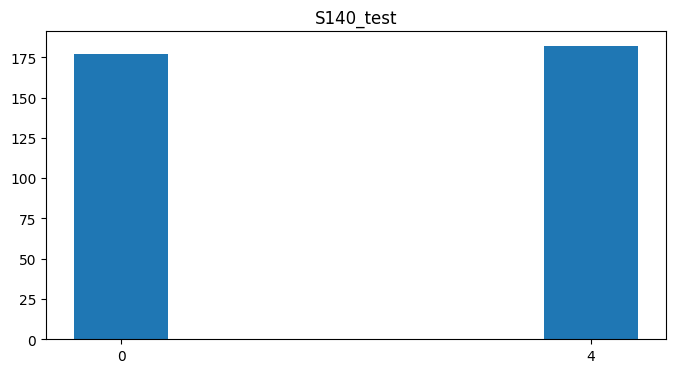

In [ ]:
val_count_test = S140_test.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count_test.index, val_count_test.values)
plt.xticks(S140_test.sentiment.unique())
plt.title("S140_test")
plt.show()

In [ ]:
#We replace the sentiment values = 4 to 1
S140_train['sentiment'] = S140_train['sentiment'].replace(4,1)
S140_test['sentiment'] = S140_test['sentiment'].replace(4,1)

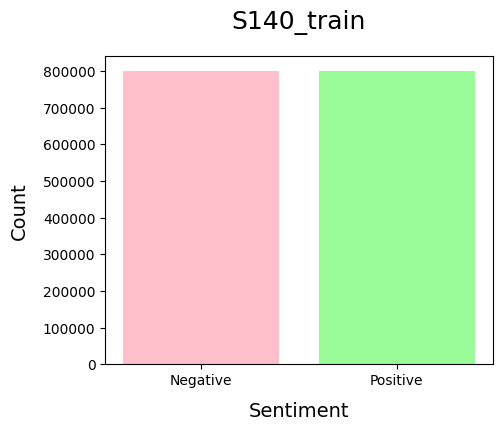

In [ ]:
val_count_train = S140_train.sentiment.value_counts()
plt.figure(figsize=(5,4))
plt.bar(val_count_train.index, val_count_train.values, color=['pink', 'palegreen'])
plt.xticks(S140_train.sentiment.unique(),labels=['Negative','Positive'])
plt.xlabel("Sentiment", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Count"    , fontdict = {'size':14}, labelpad = 10)
plt.title ("S140_train", fontdict = {'size':18}, pad = 20)
plt.show()

Let's take a peak into the Dublin-test dataset

In [ ]:
Dublin_test = pd.read_csv('/content/data/citypulse.dublin_city_council.test.csv', encoding='latin-1')
Dublin_test.head()

,id_str,text,created_at,user,sentiment,category,dataset,id
0,1190647458608635904,@DanMulhall @EamonnMallie @MoLI_Museum .@DubCi...,2019-11-02T15:10:49+00:00,NaN,positive,Public Spaces,Dublin City,1678054821
1,1136601736016224256,Love my city and community!! Rallying together...,2019-06-06T11:52:25+00:00,NaN,positive,Community and Culture,Dublin City,810929040
2,1180110345052012545,Bringing shared #micromobility e-bike &amp; e-...,2019-10-04T13:20:06+00:00,NaN,positive,Mobility,Dublin City,1650368993
3,1185632195664330752,@rothairisbeoir @__kbaker__ @cullen_ellen @wil...,2019-10-19T19:01:58+00:00,NaN,positive,Mobility,Dublin City,1657921807
4,1162620823682932737,@OConnorOisin @TUDublinEPS @IrishPedestrian @L...,2019-08-17T07:02:59+00:00,NaN,positive,Mobility,Dublin City,1514423883


In [ ]:
Dublin_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id_str      3000 non-null   int64  
 1   text        3000 non-null   object 
 2   created_at  3000 non-null   object 
 3   user        0 non-null      float64
 4   sentiment   3000 non-null   object 
 5   category    3000 non-null   object 
 6   dataset     3000 non-null   object 
 7   id          3000 non-null   int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 187.6+ KB


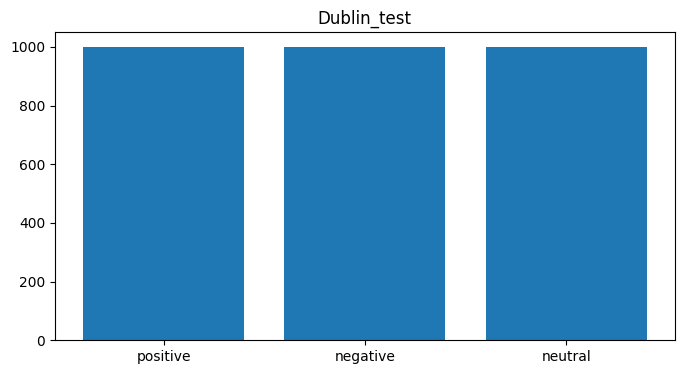

In [ ]:
Dublin_test = Dublin_test[['sentiment','text']]
Dublin_test.columns = ['sentiment', 'tweet']

val_count_dublin = Dublin_test.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count_dublin.index, val_count_dublin.values)
plt.title("Dublin_test")
plt.show()

As the S140-test dataset, we also encounter "neutral" labelled tweets. In the next cell we'll remove those tweets and change the sentiment values to 0 and 1.

In [ ]:
Dublin_test = Dublin_test.drop(Dublin_test[Dublin_test.sentiment == 'neutral'].index)   # remove neutral tagged tweets
Dublin_test['sentiment'] = Dublin_test['sentiment'].replace('negative',0)               # change sentiment value (negative ===> 0)
Dublin_test['sentiment'] = Dublin_test['sentiment'].replace('positive',1)               # change sentiment value (positive ===> 1)

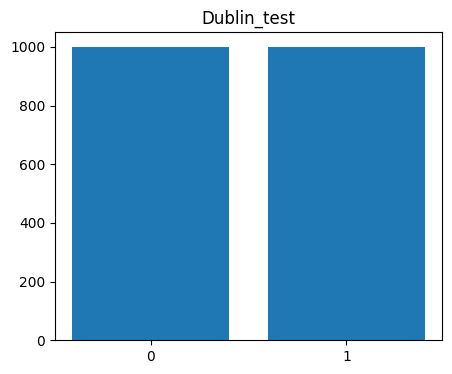

In [ ]:
val_count_dublin = Dublin_test.sentiment.value_counts()
plt.figure(figsize=(5,4))
plt.bar(val_count_dublin.index, val_count_dublin.values)
plt.title("Dublin_test")
plt.xticks(Dublin_test.sentiment.unique())
plt.show()

In [ ]:
# Storing the data in lists
s140_train_tweets, s140_train_values = list(S140_train['tweet']), list(S140_train['sentiment'])
s140_test_tweets, s140_test_values = list(S140_test['tweet']), list(S140_test['sentiment'])
dublin_test_tweets, dublin_test_values = list(Dublin_test['tweet']), list(Dublin_test['sentiment'])

print('Previewing the 10 first items of each list:\n')

print(s140_train_tweets[:10])
print(s140_train_values[:10],'\n')
print(s140_test_tweets[:10])
print(s140_test_values[:10],'\n')
print(dublin_test_tweets[:10])
print(dublin_test_values[:10])


Previewing the 10 first items of each list:

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!", '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds', 'my whole body feels itchy and like its on fire ', "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ", '@Kwesidei not the whole crew ', 'Need a hug ', "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?", "@Tatiana_K nope they didn't have it ", '@twittera que me muera ? ']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

['@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.', 'Reading my kindle2...  Love it... Lee childs is good read.', 'Ok, first assesment of the #k

Since the objective of this home assignment is not to obtain the best scores or hyperparameters, to avoid spending too much time in this task, I have decided not to apply too much preprocessing to the data, but it's important to mention that preprocessing plays an essential role in the performance of NLP systems.

Since we are working with text in tweet form, our data will be filled with urls, emojis and twitter user mentions.

Some of the preprocessing we could apply:

 * Removing twitter user mentions (Eg. "@username1111")
 * Removing stopwords (Eg. "the", "a", "in")
 * Removing hyperlinks ("https://...")
 * Stemming/Lematization

# Baseline Model

In [ ]:
X_train, y_train, X_test_140, y_test_140, X_test_dub, y_test_dub = s140_train_tweets,  s140_train_values,  s140_test_tweets,  s140_test_values,  dublin_test_tweets,  dublin_test_values

In [ ]:
tfidfvectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
tfidfvectorizer.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [ ]:
X_train    = tfidfvectorizer.transform(X_train)
X_test_140 = tfidfvectorizer.transform(X_test_140)
X_test_dub = tfidfvectorizer.transform(X_test_dub)
print(f'Data Transformed.')

Data Transformed.


In [ ]:
type(X_train)

scipy.sparse._csr.csr_matrix

In [ ]:
def model_eval(model):

    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Ground truth"    , fontdict = {'size':14}, labelpad = 10)
    plt.title (f"{model}", fontdict = {'size':18}, pad = 20)

## Training

In [ ]:
%%time

# Linear SVC model training
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)

CPU times: user 38.6 s, sys: 460 ms, total: 39.1 s
Wall time: 39.3 s


LinearSVC()

In [ ]:
%%time

# Linear Regression model training
LRmodel = LogisticRegression(C = 2, max_iter = 1000)
LRmodel.fit(X_train, y_train)

CPU times: user 4min 42s, sys: 2min 35s, total: 7min 18s
Wall time: 4min 45s


LogisticRegression(C=2, max_iter=1000)

## Evaluation

S140_test - SVC Model

              precision    recall  f1-score   support

           0       0.85      0.77      0.81       177
           1       0.80      0.87      0.83       182

    accuracy                           0.82       359
   macro avg       0.82      0.82      0.82       359
weighted avg       0.82      0.82      0.82       359



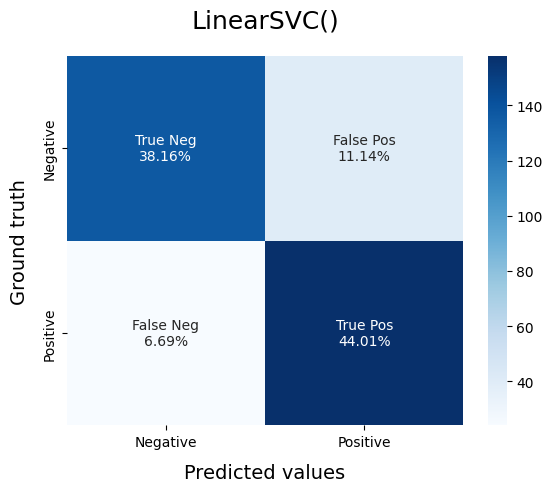

In [ ]:
X_test = X_test_140
y_test = y_test_140
model_eval(SVCmodel)

S140_test - Logistic Regression Model

              precision    recall  f1-score   support

           0       0.86      0.78      0.82       177
           1       0.80      0.88      0.84       182

    accuracy                           0.83       359
   macro avg       0.83      0.83      0.83       359
weighted avg       0.83      0.83      0.83       359



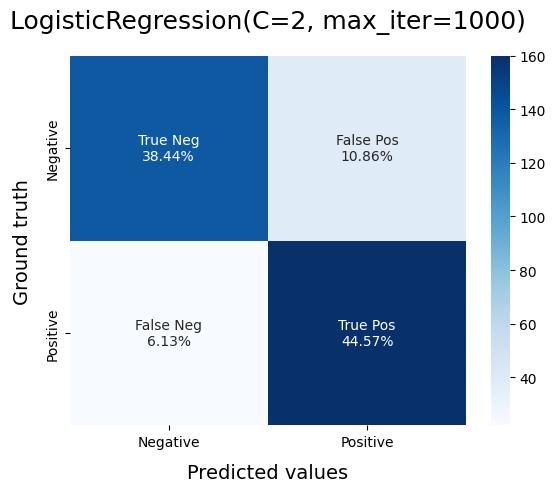

In [ ]:
X_test = X_test_140
y_test = y_test_140
model_eval(LRmodel)

Conclusion: The logistic regression model is slightly better than the SVC model. But the difference is small and the Linear SVM model is faster to train.

Dublin_test - SVC Model

              precision    recall  f1-score   support

           0       0.68      0.67      0.68      1000
           1       0.68      0.69      0.68      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.68      0.68      0.68      2000



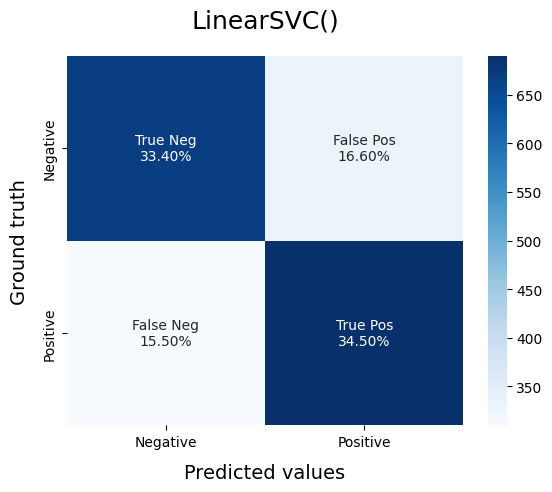

In [ ]:
X_test = X_test_dub
y_test = y_test_dub
model_eval(SVCmodel)

Dublin_test - Logistic Regression Model

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1000
           1       0.70      0.72      0.71      1000

    accuracy                           0.70      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.70      0.70      0.70      2000



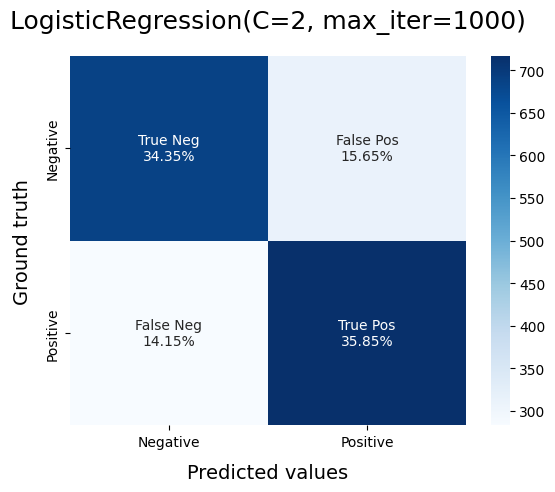

In [ ]:
X_test = X_test_dub
y_test = y_test_dub
model_eval(LRmodel)

Saving/Importing the models

In [ ]:
import pickle

In [ ]:
# Saving the models

file = open('S140-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

file = open('S140-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [ ]:
# Importing the models

#SVCmodel = pickle.load(open('S140-SVC.pickle', 'rb'))
#LRmodel = pickle.load(open('S140-LR.pickle', 'rb'))

## Sentiment prediction verification

In [ ]:
# Comment/Uncomment to select either the S140_test or Dublin_test dataset

sel_dataset = S140_test
X_test = X_test_140
y_test = y_test_140
y_pred = LRmodel.predict(X_test)

#sel_dataset = Dublin_test
#X_test = X_test_dub
#y_test = y_test_dub
#y_pred = LRmodel.predict(X_test)

if len(y_pred) == 359:
  print('Selected dataset: S140_test',)
elif len(y_pred) == 2000:
  print('Selected dataset: Dublin_test')

Selected dataset: S140_test


In [ ]:
# Comment/Uncomment to select either a concrete or random row

row = random.randint(0,len(y_pred))
#row=1346

print('Row:',row)
print('Text:',sel_dataset.tweet[row])

if sel_dataset.sentiment[row] == 0:
  print('Label: Negative')
elif sel_dataset.sentiment[row] == 1:
  print('Label: Positive')


if y_pred[row] == 0:
  print('Prediction: Negative')
elif y_pred[row] == 1:
  print('Prediction: Positive')

if sel_dataset.sentiment[row] == y_pred[row]:
  print(f'{style.GREEN}CORRECT PREDICTION')
else:
  print(f'{style.RED}INCORRECT PREDICTION')


Row: 73
Text: Back when I worked for Nike we had one fav word : JUST DO IT! :)
Label: Positive
Prediction: Negative
INCORRECT PREDICTION


In [ ]:
from wordcloud import WordCloud

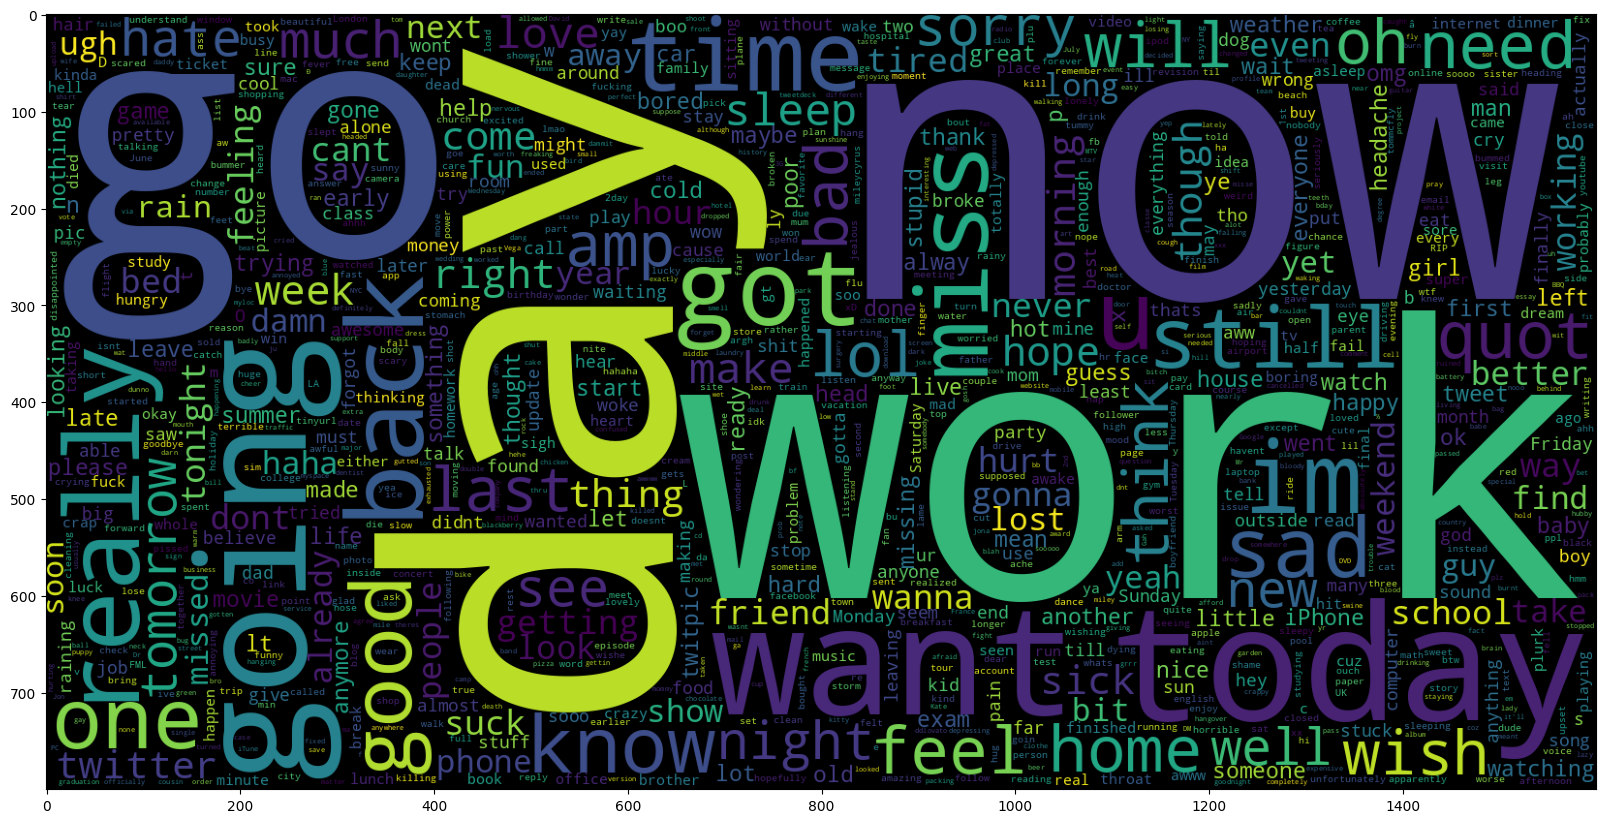

In [ ]:
data_neg = s140_train_tweets[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

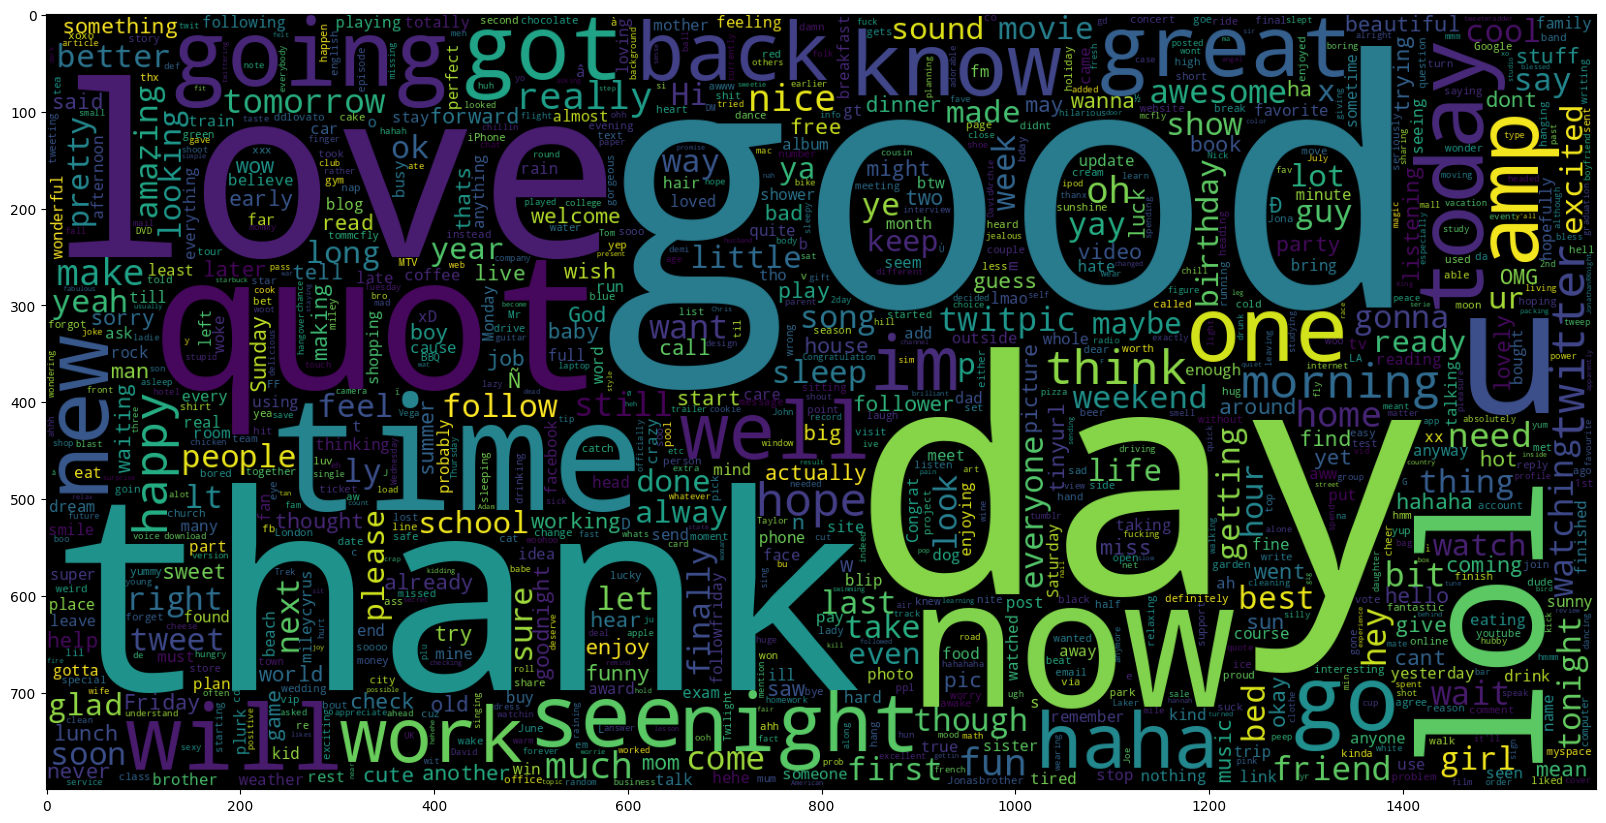

In [ ]:
data_pos = s140_train_tweets[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

# Deep Learning Model

## BERT

BERT, short for **Bidirectional Encoder Representations from Transformers**, is a Machine Learning (ML) model for natural language processing. It was developed in 2018 by researchers at Google AI Language and serves as a swiss army knife solution to 11+ of the most common language tasks, such as sentiment analysis and named entity recognition.

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

You can use both  an uncased and cased version of BERT and tokenizer. Let's try with cased version

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
sample_txt = '@DubCham Finally. Good on you Dublin Chamber - this will solve the long standing white water rafting crisis that has gripped our beloved capital.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: @DubCham Finally. Good on you Dublin Chamber - this will solve the long standing white water rafting crisis that has gripped our beloved capital.
   Tokens: ['@', 'Dub', '##C', '##ham', 'Finally', '.', 'Good', 'on', 'you', 'Dublin', 'Chamber', '-', 'this', 'will', 'solve', 'the', 'long', 'standing', 'white', 'water', 'r', '##aft', '##ing', 'crisis', 'that', 'has', 'gripped', 'our', 'beloved', 'capital', '.']
Token IDs: [137, 20691, 1658, 2522, 4428, 119, 2750, 1113, 1128, 5062, 7018, 118, 1142, 1209, 9474, 1103, 1263, 2288, 1653, 1447, 187, 17495, 1158, 5532, 1115, 1144, 9430, 1412, 12915, 2364, 119]


In [ ]:
# Special tokens
print(tokenizer.sep_token, tokenizer.sep_token_id)
print(tokenizer.cls_token, tokenizer.cls_token_id)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [ ]:
S140_train.tweet

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: tweet, Length: 1600000, dtype: object

In [ ]:
#token_lens = []
#for t in S140_train.tweet:
#  tokens = tokenizer.encode(t, max_length=512)
#  token_lens.append(len(tokens))

token_lens = []
for t in sample(S140_train.tweet.tolist(), 160000):   # Takes around 12m to tokenize all the tweets, so I'll use only a random subset of 10% of the total data
  tokens = tokenizer.encode(t, max_length=512)
  token_lens.append(len(tokens))



Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
len(token_lens)

160000

<ipython-input-57-fba87eb8c002>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


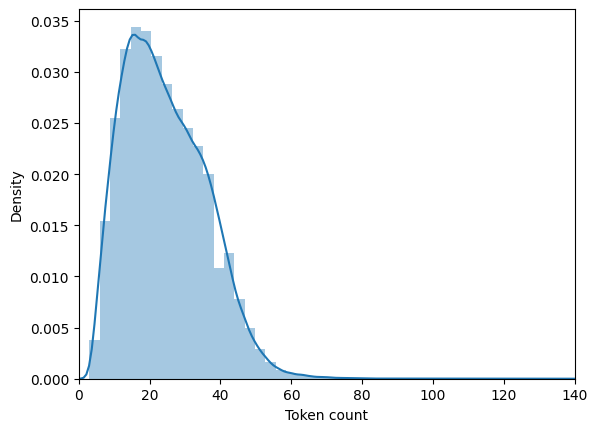

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 140]);
plt.xlabel('Token count');

We can see in the plot that the tweets usually contain less than 70 tokens. To be extra careful we'll choose a max length of 90.

In [ ]:
MAX_LEN = 90

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
S140_train.shape, S140_test.shape

((1600000, 2), (359, 2))

Since 1.6M tweets will take a lot of time to train the deep learning model, I'll use a sampled subset of 160k to avoid ultra long training times, but in a real scenario and without the limitations of Google Colab, the more data that we can use, the better.

In [ ]:
S140_train = S140_train.sample(160000)

In [ ]:
#ultra small test dataset just to make tests in the code
#S140_train = S140_train.sample(5000)

In [ ]:
S140_train.shape

(160000, 2)

We'll split the data to create a validation set

In [ ]:
train_data, val_data = train_test_split(S140_train, test_size=359, random_state=RANDOM_SEED)
test_data = S140_test

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((159641, 2), (359, 2), (359, 2))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.tweet.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
BATCH_SIZE = 16
#BATCH_SIZE = 32 # Faster to train but worse accuracy

train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 90])
torch.Size([16, 90])
torch.Size([16])


In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask'],
  return_dict=False
)

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(n_classes=2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape)      # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 90])
torch.Size([16, 90])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3311, 0.6689],
        [0.4414, 0.5586],
        [0.5161, 0.4839],
        [0.3035, 0.6965],
        [0.7419, 0.2581],
        [0.3234, 0.6766],
        [0.3975, 0.6025],
        [0.5647, 0.4353],
        [0.5963, 0.4037],
        [0.5389, 0.4611],
        [0.6142, 0.3858],
        [0.6238, 0.3762],
        [0.3804, 0.6196],
        [0.4406, 0.5594],
        [0.5799, 0.4201],
        [0.3486, 0.6514]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training


In [ ]:
EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return float(correct_predictions) / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets).detach().cpu().numpy()
      losses.append(loss.item())

  return float(correct_predictions) / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_data)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/3
----------
Train loss 0.39100648730427273 accuracy 0.8266548067225838
Val   loss 0.3134176491395287 accuracy 0.8690807799442897

Epoch 2/3
----------
Train loss 0.2744898738146895 accuracy 0.8908613701993848
Val   loss 0.3561156126468078 accuracy 0.8690807799442897

Epoch 3/3
----------
Train loss 0.2059078869825398 accuracy 0.9323983187276451
Val   loss 0.4180503345459052 accuracy 0.8746518105849582

CPU times: user 1h 58min 38s, sys: 1min 23s, total: 2h 1s
Wall time: 2h 2min 44s


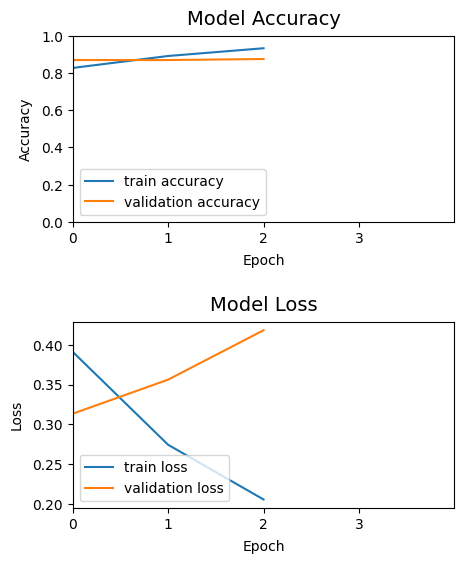

In [ ]:
fig, (at, al) = plt.subplots(2,1, figsize=(5, 6))

at.plot(history['train_acc'], label='train accuracy')
at.plot(history['val_acc'], label='validation accuracy')

at.set_title ("Model Accuracy"  , fontdict = {'size':14}, pad = 8)
at.set_ylabel("Accuracy"        , fontdict = {'size':10}, labelpad = 6)
at.set_xlabel("Epoch"           , fontdict = {'size':10}, labelpad = 6)
at.legend(loc = 'lower left')
at.set_xticks(range(0, EPOCHS+1, 1))
at.set_xlim([0, EPOCHS+1])
at.set_ylim([0, 1])

al.plot(history['train_loss'], label='train loss')
al.plot(history['val_loss'], label='validation loss')

al.set_title ("Model Loss"  , fontdict = {'size':14}, pad = 8)
al.set_ylabel("Loss"        , fontdict = {'size':10}, labelpad = 6)
al.set_xlabel("Epoch"       , fontdict = {'size':10}, labelpad = 6)
al.legend(loc = 'lower left')
al.set_xticks(range(0, EPOCHS+1, 1))
al.set_xlim([0, EPOCHS+1])

fig.tight_layout(pad=2)
plt.show()

In [ ]:
# Saving the model

torch.save(model.state_dict(), '/content/S140-DeepLearning.pth')

# Loading the model:
#model = MyModelDefinition(args)
#model.load_state_dict(torch.load('/content/S140-DeepLearning.pth'))


## Evaluation

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)

test_acc

0.8523676880222841

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_names=['negative','positive']

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.88      0.81      0.84       177
    positive       0.83      0.90      0.86       182

    accuracy                           0.85       359
   macro avg       0.86      0.85      0.85       359
weighted avg       0.85      0.85      0.85       359



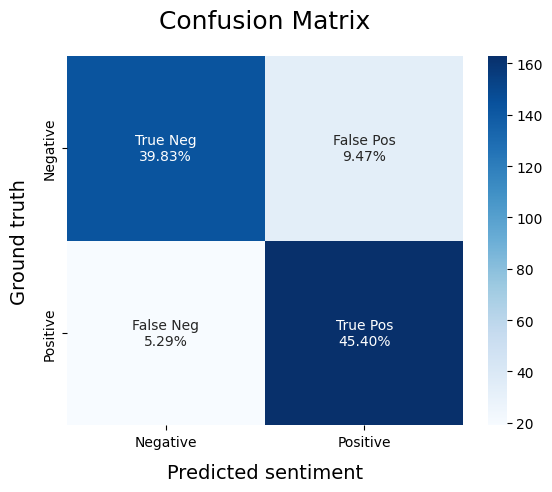

In [ ]:
def show_confusion_matrix(confusion_matrix):

  categories  = ['Negative','Positive']
  group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)]

  labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)

  hmap = sns.heatmap(confusion_matrix, annot=labels, fmt="", cmap="Blues", xticklabels = categories, yticklabels = categories)

  plt.xlabel("Predicted sentiment", fontdict = {'size':14}, labelpad = 10)
  plt.ylabel("Ground truth"       , fontdict = {'size':14}, labelpad = 10)
  plt.title ("Confusion Matrix"   , fontdict = {'size':18}, pad = 20)

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Dublin_test dataset

In [ ]:
test_data = Dublin_test

In [ ]:
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)

test_acc

0.6615

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  2000 non-null   int64 
 1   tweet      2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [ ]:
y_test.shape, y_pred.shape

(torch.Size([2000]), torch.Size([2000]))

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.70      0.57      0.63      1000
    positive       0.64      0.75      0.69      1000

    accuracy                           0.66      2000
   macro avg       0.67      0.66      0.66      2000
weighted avg       0.67      0.66      0.66      2000



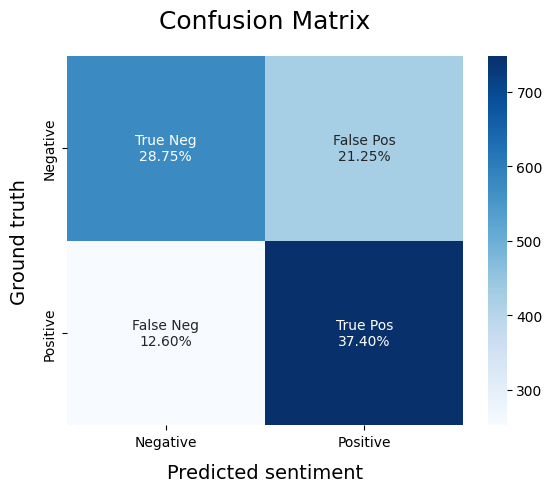

In [ ]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)